In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import randint    
import seaborn as sns

%matplotlib inline

# Pull Data

In [2]:
path = "C:/Users/Akis/OneDrive/Masters/Web Economics/Data/"
test_df = pd.read_csv(path+'test.csv')
train_df = pd.read_csv(path+'train.csv')
validation_df = pd.read_csv(path+'validation.csv')

In [3]:
budget=6250*1000
print("Our Budget is:",budget, "Fen")
print("To use over",test_df.shape[0],"bid opportunities.")
BudPerBid=budget/test_df.shape[0]
print("Budget / Bid Opportunity:",BudPerBid)

minBid=np.min(validation_df["bidprice"].values)
maxBid=np.max(validation_df["bidprice"].values)
custRange = np.arange(minBid+1, maxBid+2,5) # determines the range that bids should be in

Our Budget is: 6250000 Fen
To use over 303375 bid opportunities.
Budget / Bid Opportunity: 20.601565718994642


In [111]:
pd.set_option('display.max_columns', None)

# Functions

### Plot Metrics for bound combination for random bidding strategy

In [140]:
def plotResults(Matrix):

    ax = sns.heatmap(Matrix, linewidth=0, xticklabels=custRange, yticklabels=custRange[::-1], cmap="Greens") #, annot=True
    ax.set(xlabel='lower bound for random bid', ylabel='upper bound for random bid', title="Clicks by bounded random bids")
    for label in ax.xaxis.get_ticklabels()[::1]:
        label.set_visible(False)
    for label in ax.xaxis.get_ticklabels()[::1]:
        label.set_visible(True)
    for label in ax.yaxis.get_ticklabels()[::1]:
        label.set_visible(False)
    for label in ax.yaxis.get_ticklabels()[::1]:
        label.set_visible(True)
    plt.show()
    
    useless = 0
    return useless

### Build Matrix containing CTR for various bound combinations

In [143]:
def BuildCTRMatrix(dataframe,plot,repeats):
    for n in range(0,repeats,1):
        dataSubset = dataframe.sample(frac=0.5, replace=False)
        print(n+1,"/",repeats,"...")
        for minimumBid in custRange:
            for maximumBid in custRange: #maxBid>minBid?????
                if maximumBid>minimumBid:
                    ClickThroughRate = EvalRandBid(dataSubset,minimumBid, maximumBid)
                    CTRMatrix[minimumBid][maximumBid]=(CTRMatrix[minimumBid][maximumBid]*n+ClickThroughRate)/(n+1)
   
    return CTRMatrix

### Extract best Bounds from Results Matrix

In [144]:
def FindBestBounds(ResultsMatrix):
    print("Best CTR is:",ResultsMatrix.values.max())
    for x in custRange:
        for y in custRange:
            if ResultsMatrix[x][y]==ResultsMatrix.values.max():
                print("X:",x,"Y:",y)
                lowerBound=x
                upperBound=y
    return lowerBound, upperBound

### Evaluate a random bid value on a new set

In [145]:
def EvalRandBid(dataframe,lowerBound, upperBound):
    
    dataframe['ConstBid'] = np.random.randint(lowerBound, upperBound+1, dataframe.shape[0])

    trueValues = (dataframe["bidprice"]<dataframe['ConstBid'])
    impressions = dataframe[trueValues].shape[0]
    clicks = np.sum(dataframe[trueValues]["click"].values)
    ClickThroughRate=(clicks*100)/impressions
        
    return ClickThroughRate

# Main Code

### Determine Best Bounds Combination from Train Set

In [151]:
zero_data = np.zeros(shape=(len(custRange),len(custRange)))
zero_data[zero_data < 1] = 0.05
CTRMatrix=pd.DataFrame(zero_data,index=reversed(custRange), columns=custRange)

In [152]:
#CTRMatrix =  BuildCTRMatrix(train_df,plot=False,repeats=15)
#CTRMatrix.to_pickle("CTRMatrix.pkl")

1 / 30 ...
2 / 30 ...
3 / 30 ...
4 / 30 ...
5 / 30 ...
6 / 30 ...
7 / 30 ...
8 / 30 ...
9 / 30 ...
10 / 30 ...
11 / 30 ...
12 / 30 ...
13 / 30 ...
14 / 30 ...
15 / 30 ...
16 / 30 ...
17 / 30 ...
18 / 30 ...
19 / 30 ...
20 / 30 ...
21 / 30 ...
22 / 30 ...
23 / 30 ...
24 / 30 ...
25 / 30 ...
26 / 30 ...
27 / 30 ...
28 / 30 ...
29 / 30 ...
30 / 30 ...


In [159]:
CTRMatrix = pd.read_pickle("CTRMatrix.pkl")

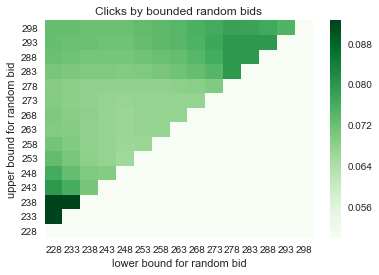

0

In [160]:
plotResults(CTRMatrix)

In [161]:
lowBound, upBound = FindBestBounds(CTRMatrix)  

### Evalute on a new data set (validation set)

In [162]:
CTR = EvalRandBid(validation_df,lowBound, upBound)

In [163]:
print(CTR)

0.07042739763861079
